In [1]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF # for generating empirical cdfs
import matplotlib.lines as mlines # needed for custom legend


# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'


# import metadata
from M194_M220_metadata import *

# import custom colormaps
from colormaps import blue_cmp, orange_cmp
# specify blue/orange colors for qualitative intervals/data
blue_qual = [blue_cmp.colors[50], blue_cmp.colors[100], blue_cmp.colors[150], blue_cmp.colors[200], blue_cmp.colors[250]]
orange_qual = [orange_cmp.colors[36], orange_cmp.colors[72], orange_cmp.colors[108], orange_cmp.colors[144], orange_cmp.colors[180], orange_cmp.colors[216], orange_cmp.colors[252]]


%matplotlib inline

# Load data

In [2]:
# set-up in/out paths
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
out_path = '/Volumes/Data/Emily/figures/fig_2_mapseq/figure_pics/'

In [4]:
omc_bin = pd.read_pickle(in_path+"M194_M220_OMC_bin.pkl")
omc_countN = pd.read_pickle(in_path+"M194_M220_OMC_countN.pkl")

# Functions

## Processing functions

In [5]:
def clean_up_data(df_dirty, to_drop = ['OB', 'ACAi', 'ACAc', 'HIP'], inj_site="OMCi"):
    """Clean up datasets so all matrices are in the same format. Function 
        (1) drops unwanted columns, e.g. negative controls or dissections of other injection sites. 
        (2) renames RN (allen acronym) as BS (my brainstem acronym)
        (3) drops neurons w/ 0 projections after dropped columns

    Args:
        df_dirty (DataFrame): Pandas dataframe (neurons x area) that needs to be processed
        to_drop (list, optional): columns to drop. Defaults to ['OB', 'ACAi', 'ACAc', 'HIP'].
        inj_site (str, optional): Injection site. Defaults to "OMCi".

    Returns:
        DataFrame: Cleaned up data in dataframe format.
    """

    # 1. drop unused areas
    dropped = df_dirty.drop(to_drop, axis=1)

    # 2. change RN to bs
    replaced = dropped.rename(columns={'RN':'BS'})

    # 3. drop neurons w/ 0 projections after removing negative regions
    if type(inj_site)==str:
        nodes = replaced.drop([inj_site], axis=1).sum(axis=1)
    else:
        nodes = replaced.drop(inj_site, axis=1).sum(axis=1)
    
    n_idx = nodes > 0 # non-zero projecting neurons
    clean = replaced[n_idx]
    
    return clean



In [6]:
def sort_by_celltype(proj, it_areas=["OMCc", "AUD", "STR"], ct_areas=["TH"],
                      pt_areas=["AMY","HY","SNr","SCm","PG","PAG","BS"],
                      sort=True):
    """
    Function takes in projection matrix and outputs matrix sorted by the 3 major celltypes:
    - IT = intratelencephalic (projects to cortical and/or Striatum), type = 10
    - CT = corticalthalamic (projects to thalamus w/o projection to brainstem), type = 100
    - PT = pyramidal tract (projects to brainstem += other areas), type = 1000
    Returns single dataframe with cells sorted and labelled by 3 cell types (IT/CT/PT)

    Args:
        proj (DataFrame): pd.DataFrame of BC x area. Entries can be normalized BC or binary.
        it_areas (list, optional): Areas to determine IT cells. Defaults to ["OMCc", "AUD", "STR"].
        ct_areas (list, optional): Areas to determine CT cells. Defaults to ["TH"]. Don't actually use this...
        pt_areas (list, optional): Areas to determine PT cells. Defaults to ["AMY","HY","SNr","SCm","PG","PAG","BS"].
        sort (bool, optional): Whether to sort by cell type or return w/ original index. Defaults to True.
    
    Returns:
        df_out (DataFrame): Returns dataframe with extra column (type) labelled and sorted by cell type
    """
    
    ds=proj.copy()
 
    # Isolate PT cells
    pt_counts = ds[pt_areas].sum(axis=1)
    pt_idx = ds[pt_counts>0].index
    ds_pt = ds.loc[pt_idx,:]
    ds_pt['type'] = "PT"

    # Isolate remaining non-PT cells
    ds_npt = ds.drop(pt_idx)

    # Identify CT cells by thalamus projection
    th_idx = ds_npt['TH'] > 0
    ds_th = ds_npt[th_idx]
    if sort:
        ds_th = ds_th.sort_values('TH', ascending=False)
    ds_th['type'] = "CT"

    # Identify IT cells by the remaining cells (non-PT, non-CT)
    ds_nth = ds_npt[~th_idx]
    if sort:
        ds_nth = ds_nth.sort_values(it_areas,ascending=False)
    ds_nth['type'] = "IT"

    # combine IT and CT cells
    ds_npt = pd.concat([ds_nth, ds_th])

    # combine IT/CT and PT cells
    if sort:
        sorted = pd.concat([ds_npt,ds_pt],ignore_index=True)
        df_out=sorted.reset_index(drop=True)
    else:
        df_out = pd.concat([ds_npt,ds_pt]).sort_index()

    return(df_out)



In [7]:
def dfs_preprocess_counts(df_list, drop=["type"], 
                          norm_by="inj_median", inj_site="OMCi", medians=None):
    """Take dataframe and process it for downstream analysis. Can be binarized or 
    non-binarized data.

    Args:
        df_list (list): List of dataframes, 
        drop (list, optional): List of columns to drop before returning. Defaults to ["OMCi", "type"].
        norm_by (str, optional): How to normalize counts. Can be "inj_median" or 'all_median' or "given". Defaults to "inj_median".
        inj_site (str, optional): What column to use for injection norm. Defaults to "OMCi".
        medians (list, optional): if norm_by=="given", uses list of medians (same length as df_list) to normalize dataframes. Defaults to None.

    Returns:
        out_list (list): List of dataframes same order as input list.
    """
    
    out_list = []
    norms_out = []
    for i in range(len(df_list)):
        df = df_list[i].drop(drop, axis=1)

        if norm_by=="inj_row":
            # normalize on neuron by neuron basis to injection site value
            out_df = df.div(df[inj_site], axis=0)
        elif norm_by=="given":
            out_df = df/medians[i]
        elif norm_by=="inj_mean":
            vals = df[inj_site].values.flatten()
            mean = np.mean(vals)
            norms_out.append(mean)
            out_df = df/mean
        else:
            # normalize by non-zero median of injection site
            if norm_by=="inj_median":
                vals = df[inj_site].values.flatten() # added injection site median
            # normalize by median of all non-zero values median across whole dataset
            elif norm_by=="all_median":
                vals = df.values.flatten()
            idx = vals.nonzero() # only use non-zero ncounts for determining median
            plot = vals[idx]
            median = np.median(plot)
            norms_out.append(median)
            out_df = df/median

        for j in range(len(drop)):
            out_df[drop[j]] = df_list[i][drop[j]] # add dropped columns back in, can preserve labels
        
        out_list.append(out_df)

    if len(norms_out)>0:
        return(norms_out, out_list)
    else:
        return(out_list)

In [8]:
def dfs_to_cdf(df_list, plot_areas, resolution=1000, metadata=metadata):
    """Takes in list of DFs of count(N) data and returns dataframe w/ cdf data that can be plotted.
    Returned Dataframe includes metadata

    Args:
        df_list (list): list of DataFrames of count(N) data.
        plot_areas (list): List of strings of areas to calculate cdfs.
        resolution (int, optional): Used to determine resolution of cdf line. Defaults to 1000.
        medatadata (df, optional): Metadata where row corresponds to df_list indices. Defaults to metadata.
    Returns:
        cdf_df (DataFrame): Dataframe of cdf summary values
        all_ecdfs (list): Empirical cdf 
    """

    # combine all DFs into one df labelled w/ metadata
    all_bc = pd.DataFrame(columns=list(df_list[0].columns)+["mice", "species", "dataset"])
    for i in range(metadata.shape[0]):
        df = df_list[i].copy(deep=True)
        df['mice'] = metadata.loc[i, 'mice']
        df['species'] = metadata.loc[i, "species"]
        df['dataset'] = metadata.loc[i, "dataset"]
        all_bc = pd.concat([all_bc, df])

    all_bc = all_bc.reset_index(drop=True)

    cdf_df = pd.DataFrame(columns=["x", "cdf", "mice", "species", "dataset", "area"])

    all_ecdfs = {}

    # calculate cdf by area, then add by mouse
    for area in plot_areas:
        # just use nonzero BC
        area_idx = all_bc[area] > 0
        area_bc = all_bc.loc[area_idx, [area, "mice", "species", "dataset"]]
        # get min/max for each area to set cdf bounds
        area_min = area_bc[area].min()
        area_max = area_bc[area].max()

        for i in range(metadata.shape[0]):
            micei = metadata.loc[i, 'mice']
            mice_bc = area_bc[area_bc['mice']==micei]
            if mice_bc[area].sum()==0:
                print("NO BARCODES, cannot compute ECDF for", area, metadata.loc[i,'mice'])
            else:
                # print(area, metadata.loc[i,"mice"])
                ecdf = ECDF(mice_bc[area])
                x = np.logspace(np.log10(area_min), np.log10(area_max), num=resolution)
                y = ecdf(x)

                int = pd.DataFrame({"x":x, "cdf":y, "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"], 
                                    "dataset":metadata.loc[i,"dataset"], "area":area})
                cdf_df = pd.concat([cdf_df, int])
                all_ecdfs[micei+"_"+area] = ecdf

    return(cdf_df, all_ecdfs)

## Plotting functions

In [9]:
def dot_plot(data, subset=None, title=None, err="se", add_legend=False,
                              to_plot="proportion", ylim=(0), fig_size=(3.5,3.5),
                              jitter=False, alpha=0.3):
    """Plot closed circle of value per area for data.

    Args:
        data (DataFrame): Dataframe of proportions, included downsampled data.
        subset (list, optional): List of what to subset on to plot. Defaults to None.
        title (str, optional): Title for plot. Defaults to None.
        err (str, optional): Error to plot, can be "ci", "pi", "se", or "sd". Defaults to "se".
        add_legend (bool, optional): Whether to add legend labeling mean/err. Defaults to False.
        to_plot (str, optional): Column to plot. Defaults to "proportion".
        ylim (tuple, optional): lower bound for yaxis. Defaults to (0).
        fig_size (tuple, optional): Dimensions (in inches) of plot. Defaults to (3.5,3.5).
        jitter (bool, optional): Whether to have overlapping points. Defaults to False.
        alpha (float, optional): How much transparency for points. Defaults to 0.3.
    """

    if subset:
        df = data[data[subset[0]]==subset[1]]
    else:
        df = data.copy()

    fig, ax = plt.subplots()

    sns.stripplot(x='species', y=to_plot, hue="species",
                   dodge=False, data=df, jitter=jitter, 
                   size=10, alpha=alpha)
    sns.pointplot(df, x="species", y=to_plot, hue="species",
              dodge=False, marker="+", 
              ls="", zorder=10, errorbar="se")



    ax.set_xlabel("")

    plt.title(title, size=20)
    plt.ylim(ylim) # make sure y axis starts at 0
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(fig_size[0],fig_size[1])

    if add_legend:
        legend = mlines.Line2D([], [], color="black", marker="[]", linewidth=0, label="mean, "+err)
        plt.legend(handles=[legend], loc="lower right")
    else:
        plt.legend([],[], frameon=False)


    return(fig)

In [10]:
def plot_cdf(data, plot_areas, log=True, title="", color_by="species", colors=[blue_cmp.colors[255], orange_cmp.colors[255]],
             individual=True, meta=metadata, legend=True, fig_size=(3,3), calc_cdf=True):
    """Takes in countN data and returns cdf plots

    Args:
        data (list): list of DataFrames of count(N), where each element in animal
        plot_areas (list): list of strings of areas to include in final output
        log (bool, optional): Whether to use log on axis scale. Defaults to True.
        title (str, optional): figure title. Defaults to "".
        color_by (str, optional): Can be "mice", "species", or "dataset", what to label as metadata. Defaults to "species".
        colors (list, optional): colors used to label cdfs. Defaults to [blue_cmp.colors[255], orange_cmp.colors[255]].
        individual (bool, optional): _description_. Defaults to True.
        meta (_type_, optional): _description_. Defaults to metadata.
        calc_cdf (bool, optional): Whether to calcualte cdf or not. Defaults to True.
    """


    # calculate ecdf per animal and put into dataframe
    if calc_cdf:
        cdf_df, foo = dfs_to_cdf(data, plot_areas=plot_areas, metadata=meta)
    else:
        cdf_df = data.copy()

    # calculate number of axes needed
    n = math.ceil(len(plot_areas)/5) # round up divide by 4 = axs rows

    if len(plot_areas)==1:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        ax_list = [ax]
    else:
        fig, axs = plt.subplots(n, 5, figsize=(20, 5*n))
        ax_list = axs.flat

    i = 0
    for ax in ax_list:

        if i < len(plot_areas):
            area = plot_areas[i]

            plot = cdf_df[cdf_df['area']==area]
            
            groups = plot[color_by].unique()

            plot_1 = plot[plot[color_by] ==groups[0]]
            plot_2 = plot[plot[color_by] ==groups[1]]

            if individual:
                sns.lineplot(plot_1, x="x", y="cdf", estimator=None, units="mice", color=colors[0], ax=ax) # plots individual mice
                sns.lineplot(plot_2, x="x", y="cdf", estimator=None, units="mice", color=colors[1], ax=ax) # plots individual mice
            else: 
                sns.lineplot(plot_1, x="x", y="cdf", ax=ax) # plots mean ci95
                sns.lineplot(plot_2, x="x", y="cdf", ax=ax) # plots mean ci95
            
            # get rid of top and right axis
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            if log:
                ax.set_xscale("log")
            ax.set_xlabel("Normalized Counts")

            ax.set_title(area)
            i+=1
        else:
            ax.axis('off')

    # create cutom legend
    if legend:
        colors = [colors[0], colors[1]]
        lines = [mlines.Line2D([0], [0], color=c, linewidth=3) for c in colors]
        labels = [groups[0], groups[1]]
        fig.legend(lines,labels, bbox_to_anchor=(0.75, 0.935))

    # increase text size
    plt.rcParams.update({'font.size': 12})

    if title!="":
        plt.suptitle(title, y=0.93, size=20)
    elif title=="":
        plt.suptitle("By "+color_by, y=0.93, size=20)

    # erase minor ticks
    plt.minorticks_off()

    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(fig_size[0],fig_size[1])

    return(fig)

# Data pre-processing

In [11]:
# initial processing
# binary processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# normalized count (countN) processing
omc_cleanN = [clean_up_data(df) for df in omc_countN]
omc_typeN = [sort_by_celltype(df) for df in omc_cleanN]
means, omc_preprocessN = dfs_preprocess_counts(omc_typeN, norm_by="inj_mean") # normalize by injection mean
medians, omc_preprocessN_med = dfs_preprocess_counts(omc_typeN, norm_by="inj_median")


# Infectivity
- Plots for supplementary fig No. 4

In [12]:
# Plot unique barcodes by species

infect_df = pd.DataFrame(columns=["Unique Barcodes", "mice", "species", "dataset"])

for i in range(metadata.shape[0]):
    infect_df.loc[i,"Unique Barcodes"] = omc_type[i].shape[0]
    infect_df.loc[i, "mice"] = metadata.loc[i,"mice"]
    infect_df.loc[i,"species"] = metadata.loc[i, "species"]
    infect_df.loc[i, "dataset"] = metadata.loc[i, "dataset"]

print("Mean")
display(infect_df.groupby("species")["Unique Barcodes"].mean())

print("SEM")
infect_df.groupby("species")["Unique Barcodes"].sem()


Mean


species
MMus       14318.8
STeg    711.285714
Name: Unique Barcodes, dtype: object

SEM


species
MMus    2545.992231
STeg      99.115304
Name: Unique Barcodes, dtype: float64

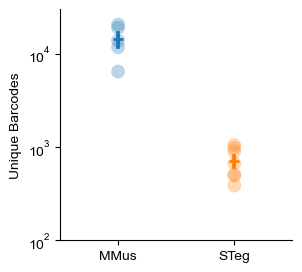

In [13]:

dot_plot(infect_df, to_plot="Unique Barcodes", fig_size=(3,3))
plt.yscale("log")
plt.ylim(100, 30000)
plt.minorticks_off()
# plt.savefig(out_path+"infectivity_uBC_dotplot.svg", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_5993/1917251269.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_5993/1917251269.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


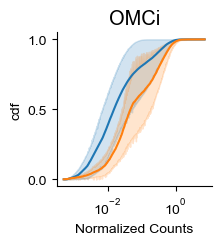

In [14]:
# plot barcode count per neuron for injection site (OMCi)

# NO WITHIN SAMPLE NORM - i.e. only normalized to spike-ins
plot_cdf(omc_typeN, plot_areas=["OMCi"], color_by="species",
         title=None, legend=False, individual=False, fig_size=(2,2))
plt.title("OMCi")
# plt.savefig(out_path+"omci_rnaspike_norm_cdf.svg", dpi=300, bbox_inches="tight")
plt.show()


Mean
species
MMus    0.039977
STeg    0.129038
Name: inj_med, dtype: float64

SEM
species
MMus    0.022244
STeg    0.041240
Name: inj_med, dtype: float64
MannwhitneyuResult(statistic=6.0, pvalue=0.07323232323232323)


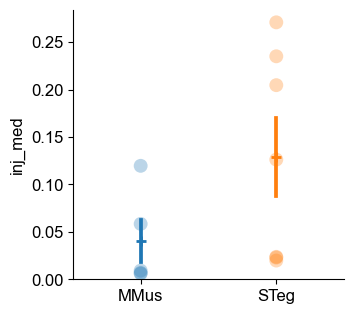

In [15]:
# take medians for each animal
omc_typeN[0]["OMCi"].median()
medians_omci = []
for i in range(metadata.shape[0]):
    medians_omci.append(omc_typeN[i]["OMCi"].median())

omci_med = metadata.copy()
omci_med["inj_med"] = medians_omci
omci_med["area"] = "OMCi"

# calcualte mean, sem for each species
print("Mean")
print(omci_med.groupby("species")["inj_med"].mean())

print("\nSEM")
print(omci_med.groupby("species")["inj_med"].sem())

# Mann whitney u test
mm_med = omci_med[omci_med["species"]=="MMus"]
st_med = omci_med[omci_med["species"]=="STeg"]

print(stats.mannwhitneyu(mm_med["inj_med"], st_med["inj_med"]))

dot_plot(omci_med, to_plot="inj_med")
plt.show()
